In [5]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from timeit import default_timer as timer
import lightning as L
from torch.utils.data import DataLoader, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Setup training data
train_data = datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=ToTensor(),
)

# Setup testing data
test_data = datasets.MNIST(
    root='./data/',
    train=False, # get test data
    download=True,
    transform=ToTensor()
)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:06<00:00, 1.43MB/s]


Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 272kB/s]


Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]


Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.50MB/s]


Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw



In [56]:
train_transform = transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data/', download=False, train=True, transform=train_transform)
test_dataset = datasets.MNIST('./data/', download=False, train=False, transform=val_transform)
test_dataset, val_dataset = random_split(test_dataset, [0.50, 0.50])

In [15]:
train_dataset[2][0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, '1')

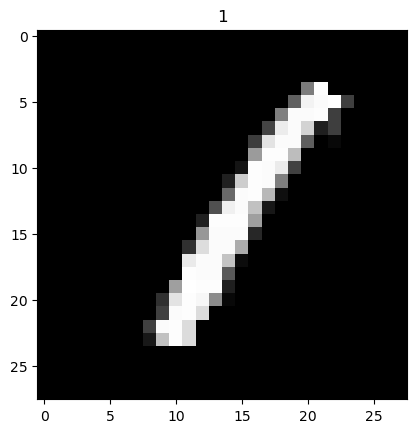

In [68]:
plt.imshow(train_dataset[3][0].squeeze(), cmap="gray") # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(train_dataset[3][1])

In [ ]:
import numpy as np
import pandas as pd
import altair as alt
import os
from typing import Union
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from torchvision import datasets
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.manifold import TSNE
from sklearn.cluster import k_means

from network import SmallBackbone, ClassifierHead, SmallCNN

def embed_val_given_ckpt_path(
    ckpt_path: str = "log/lightning_logs/version_1/checkpoints/best-epoch=39-val_loss=0.0433.ckpt", 
    config_path: str = "config.yaml"):
    
    config = OmegaConf.load(config_path)

    # initialize model
    backbone = SmallBackbone(
        num_channels_1=config.model.num_channels_1, 
        num_channels_2=config.model.num_channels_1, 
        emb_dim=config.model.emb_dim, 
        p=config.model.dropout)

    head = ClassifierHead(
        emb_dim=config.model.emb_dim, 
        num_classes=10, 
        p=config.model.dropout)

    model = SmallCNN.load_from_checkpoint(
        checkpoint_path=ckpt_path,
        backbone=backbone,
        head=head)
    model.eval()

    # load val dataset
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_train_val = datasets.MNIST("./data/", download=True, train=True, transform=val_transform)

    split = torch.load("data/MNIST/train_val_split.pt")
    _, val_idx = split["train_idx"], split["val_idx"]

    val_dataset = Subset(full_train_val, val_idx)

    val_loader = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.data.batch_size, 
        num_workers=config.data.num_workers, 
        pin_memory=True, 
        persistent_workers=True)

    # embedd images
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            data, labels = batch
            embeddings = model.backbone(data)
            all_embeddings.append(embeddings)
            all_labels.append(labels)

    all_embeddings = torch.concat(all_embeddings)
    all_labels = torch.concat(all_labels)
    
    return all_embeddings, all_labels

def tsne_and_cluster_from_ckpt(    
    ckpt_dir: str = "log/lightning_logs/version_1/checkpoints/",
    ckpt_file: str = "best-epoch=39-val_loss=0.0433.ckpt", 
    config_path: str = "config.yaml"):
    
    ckpt_path = os.path.join(ckpt_dir, ckpt_file)
    embeddings, labels = embed_val_given_ckpt_path(ckpt_path, config_path)
    
    tsne = TSNE(
        n_components=2, 
        learning_rate='auto'
        ).fit_transform(embeddings)

    centroids, clusters, inertia = k_means(
        tsne, 
        n_clusters=10,
        n_init=5)
    
    return embeddings, labels, tsne, clusters

## Plotting functions

def plot_tsne(
    embeddings: Union[np.ndarray, torch.Tensor], 
    labels: Union[np.ndarray, torch.Tensor]):
    
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap="tab10", s=5, alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes", loc="best", bbox_to_anchor=(1,1))
    plt.title("t-SNE")
    plt.show()

def plot_tsne_color_toggle(embeddings, clusters, labels, centroids=None, point_size=25, save_html=None):
    """
    Interactive Altair plot for 2D embeddings with a toggle to color by 'cluster' or 'label'.

    Args:
        embeddings : (N, 2) array-like – 2D coords (e.g., t-SNE).
        clusters   : (N,) array-like – cluster ids.
        labels     : (N,) array-like – true labels.
        centroids  : (K, 2) array-like or None – centroids in the same 2D space (optional).
        point_size : int – scatter marker size.
        save_html  : str or None – path to save as HTML.

    Returns:
        alt.Chart
    """
    # ---- validation ----
    X = np.asarray(embeddings)
    c = np.asarray(clusters)
    y = np.asarray(labels)
    if X.ndim != 2 or X.shape[1] != 2:
        raise ValueError("embeddings must be shape (N, 2)")
    if len(c) != len(X) or len(y) != len(X):
        raise ValueError("clusters and labels must each have length N")

    # ---- altair setup ----
    alt.data_transformers.disable_max_rows()

    df = pd.DataFrame({
        "x": X[:, 0],
        "y": X[:, 1],
        "cluster": c.astype(str),
        "label": y.astype(str),
    })

    # Toggle param bound to radio buttons
    color_toggle = alt.param(
        name="color_by",
        value="cluster",
        bind=alt.binding_radio(options=["cluster", "label"], name="Color by: ")
    )

    # Points layer: compute a virtual field "color" based on the toggle
    points = (
        alt.Chart(df)
        .transform_calculate(
            color="color_by == 'cluster' ? datum.cluster : datum.label"
        )
        .mark_point(filled=True, opacity=0.75)
        .encode(
            x=alt.X("x:Q", axis=alt.Axis(title="t-SNE 1")),
            y=alt.Y("y:Q", axis=alt.Axis(title="t-SNE 2")),
            color=alt.Color("color:N", legend=alt.Legend(title="Color")),
            tooltip=[
                alt.Tooltip("cluster:N", title="Cluster"),
                alt.Tooltip("label:N", title="Label"),
                alt.Tooltip("x:Q", format=".2f"),
                alt.Tooltip("y:Q", format=".2f"),
            ],
            size=alt.value(point_size),
        )
        .add_params(color_toggle)
    )

    chart = points

    # Optional centroids: only visible when color_by == 'cluster'
    if centroids is not None:
        centroids = np.asarray(centroids)
        if centroids.ndim != 2 or centroids.shape[1] != 2:
            raise ValueError("centroids must be shape (K, 2)")
        dfc = pd.DataFrame({
            "cx": centroids[:, 0],
            "cy": centroids[:, 1],
            "cluster": [str(i) for i in range(len(centroids))]
        })
        centroid_layer = (
            alt.Chart(dfc)
            .transform_calculate(
                centroid_opacity="color_by == 'cluster' ? 1 : 0"
            )
            .mark_point(shape="cross", size=220, filled=False, stroke="black", strokeWidth=1.5)
            .encode(
                x="cx:Q", y="cy:Q",
                opacity=alt.Opacity("centroid_opacity:Q", legend=None),
                tooltip=[alt.Tooltip("cluster:N", title="Centroid (cluster)")]
            )
        )
        chart = points + centroid_layer

    chart = chart.properties(
        width=700, height=600,
        title="t-SNE (toggle color by cluster/label)"
    ).interactive()

    if save_html:
        chart.save(save_html)

    return chart

In [1]:
from utils import tsne_and_cluster_from_ckpt, plot_tsne_color_toggle

In [16]:
embeddings, labels, tsne, clusters = tsne_and_cluster_from_ckpt(ckpt_file='epoch-epoch=00-val_loss=0.4428.ckpt')

plot_tsne_color_toggle(tsne, clusters, labels)

C:\Users\nicco\AppData\Local\Temp\ipykernel_62344\3283488897.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  split = torch.load("data/MNIST/train_val_split.pt")


alt.Chart(...)